# Pun Experiment Explorer

Interactive exploration of contrastive activation data from Llama-3.1-70B-Instruct on 50 pun/straight cloze pairs.

**Contents:**
1. Data overview and separation metrics
2. Static visualizations (PCA, contrastive projections, histograms)
3. Interactive 3D layer explorer (drag to rotate, slider across 80 layers)
4. Holdout analysis — does the contrastive direction generalize?

In [1]:
from pathlib import Path
import json
import numpy as np
from IPython.display import HTML, display, Image
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

from analyze_activations import (
    load_activations, get_pair_indices, analyze_all_layers,
    contrastive_projection, contrastive_direction, cohens_d,
    stable_contrastive_projections, holdout_analysis,
    load_detailed_predictions, pun_boost_per_pair,
)
from puns_viz import make_layer_viz

In [2]:
RAW_DIR = Path("results/raw_activations")
FIG_DIR = Path("results/figures")

META_FILE = RAW_DIR / "llama31_70b_instruct_pred_c_meta.json"
PRED_FILE = RAW_DIR / "llama31_70b_instruct_pred_c_detailed_preds.json"

meta, layer_data, layer_indices = load_activations(META_FILE)
pair_ids, is_funny, is_straight = get_pair_indices(meta)

print(f"Model: {meta['model']}")
print(f"Position: {meta['position']}")
print(f"Layers: {len(layer_indices)} (0-{layer_indices[-1]})")
print(f"Prompts: {meta['n_prompts']} ({is_straight.sum()} straight, {is_funny.sum()} funny)")
print(f"Hidden dim: {meta['hidden_dim']}")

Model: meta-llama/Llama-3.1-70B-Instruct
Position: pred_c
Layers: 80 (0-79)
Prompts: 100 (50 straight, 50 funny)
Hidden dim: 8192


---
## 1. Separation Metrics Across Layers

Fisher separation and Cohen's d measure how well straight and funny contexts are distinguished at each layer.

In [3]:
layer_results = analyze_all_layers(layer_data, meta)

peak_fisher = layer_results['peak_fisher_layer']
peak_cd = layer_results['peak_cohens_d_layer']
peak_cd_idx = layer_indices.index(peak_cd)

print(f"Fisher peak: layer {peak_fisher} (score={layer_results['fisher'][layer_indices.index(peak_fisher)]:.3f})")
print(f"Cohen's d peak: layer {peak_cd} (d={layer_results['cohens_d'][peak_cd_idx]:.2f})")

Fisher peak: layer 42 (score=0.262)
Cohen's d peak: layer 77 (d=1.34)


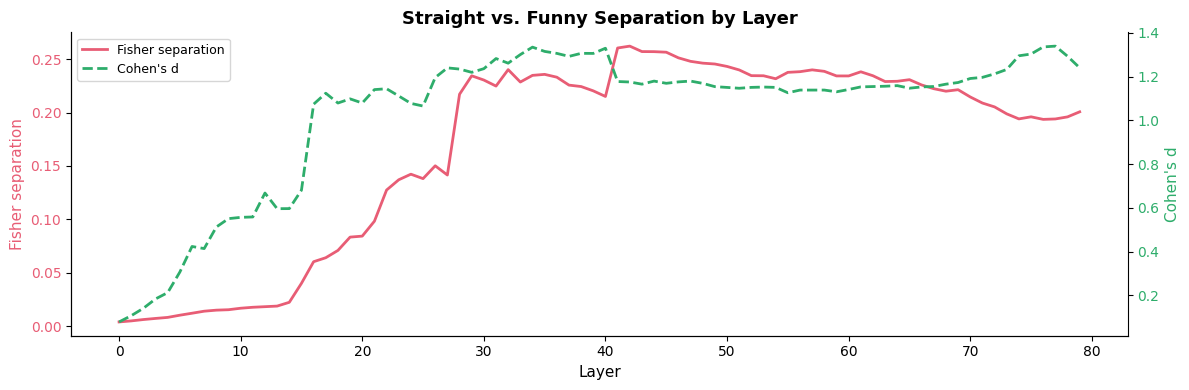

In [4]:
fig, ax1 = plt.subplots(figsize=(12, 4))

ax1.plot(layer_indices, layer_results['fisher'], color='#E85D75', lw=2, label='Fisher separation')
ax1.set_xlabel('Layer', fontsize=11)
ax1.set_ylabel('Fisher separation', fontsize=11, color='#E85D75')
ax1.tick_params(axis='y', labelcolor='#E85D75')
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

ax2 = ax1.twinx()
ax2.plot(layer_indices, layer_results['cohens_d'], color='#2EAD6B', lw=2, ls='--', label="Cohen's d")
ax2.set_ylabel("Cohen's d", fontsize=11, color='#2EAD6B')
ax2.tick_params(axis='y', labelcolor='#2EAD6B')
ax2.spines['top'].set_visible(False)

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, fontsize=9, loc='upper left')
ax1.set_title('Straight vs. Funny Separation by Layer', fontsize=13, fontweight='bold')
fig.tight_layout()
plt.show()

---
## 2. Static Visualizations

Contrastive projection at the peak Cohen's d layer, and 1D projection histograms.

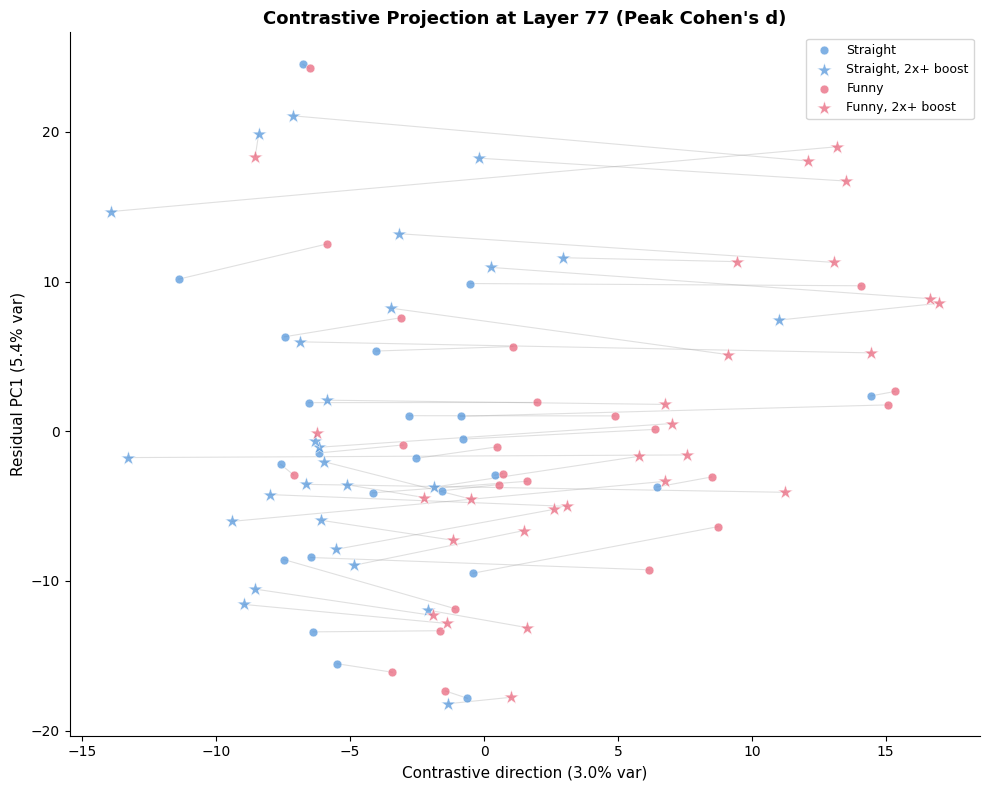

In [5]:
# Contrastive scatter at peak layer
X_peak = layer_data[peak_cd]
X_proj, _, var_ratios = contrastive_projection(X_peak, meta, n_components=2)

# Load pun boost markers
detailed_preds = load_detailed_predictions(PRED_FILE)
boost_ratios = pun_boost_per_pair(detailed_preds)
has_boost = np.array([boost_ratios.get(s['pair_id'], 1.0) >= 2.0 for s in meta['samples']])

fig, ax = plt.subplots(figsize=(10, 8))

# Pair lines
for pid in sorted(set(pair_ids)):
    mask = pair_ids == pid
    if mask.sum() == 2:
        pts = X_proj[mask]
        ax.plot(pts[:, 0], pts[:, 1], color='#999', alpha=0.3, lw=0.8, zorder=1)

# Points with boost markers
groups = [
    (is_straight & ~has_boost, '#4A90D9', 'o', 40,  'Straight'),
    (is_straight & has_boost,  '#4A90D9', '*', 120, 'Straight, 2x+ boost'),
    (is_funny & ~has_boost,    '#E85D75', 'o', 40,  'Funny'),
    (is_funny & has_boost,     '#E85D75', '*', 120, 'Funny, 2x+ boost'),
]
for mask, color, marker, size, label in groups:
    if mask.sum():
        ax.scatter(X_proj[mask, 0], X_proj[mask, 1], c=color, marker=marker,
                   s=size, alpha=0.7, label=label, edgecolors='white', lw=0.5, zorder=2)

ax.set_xlabel(f'Contrastive direction ({var_ratios[0]:.1%} var)', fontsize=11)
ax.set_ylabel(f'Residual PC1 ({var_ratios[1]:.1%} var)', fontsize=11)
ax.set_title(f'Contrastive Projection at Layer {peak_cd} (Peak Cohen\'s d)', fontsize=13, fontweight='bold')
ax.legend(fontsize=9, loc='best')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
fig.tight_layout()
plt.show()

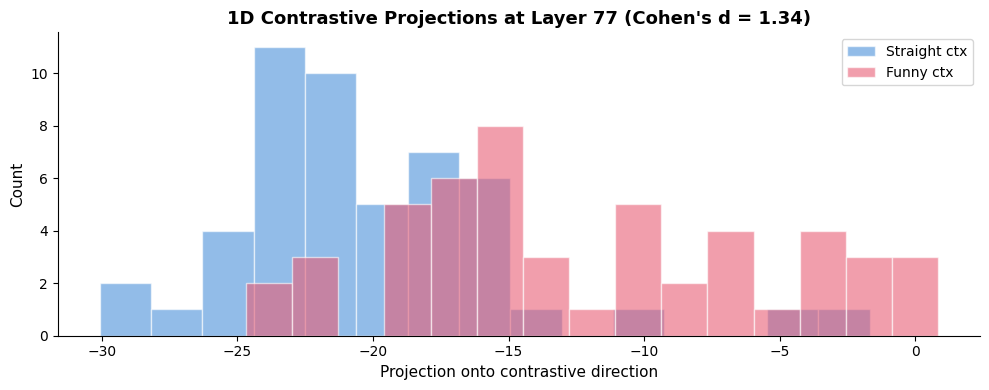

In [6]:
# 1D projection histogram at peak layer
direction = contrastive_direction(X_peak, meta)
projections = X_peak @ direction

fig, ax = plt.subplots(figsize=(10, 4))
ax.hist(projections[is_straight], bins=15, alpha=0.6, color='#4A90D9', label='Straight ctx', edgecolor='white')
ax.hist(projections[is_funny], bins=15, alpha=0.6, color='#E85D75', label='Funny ctx', edgecolor='white')
ax.set_xlabel('Projection onto contrastive direction', fontsize=11)
ax.set_ylabel('Count', fontsize=11)
ax.set_title(f'1D Contrastive Projections at Layer {peak_cd} (Cohen\'s d = {layer_results["cohens_d"][peak_cd_idx]:.2f})',
             fontsize=13, fontweight='bold')
ax.legend(fontsize=10)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
fig.tight_layout()
plt.show()

---
## 3. Interactive 3D Layer Explorer

- **Drag** on the plot to rotate in 3D
- **Layer slider** to move through all 80 layers (or press Play for animation)
- **Hover** over a point for detailed tooltip (sentence, pun words, predictions, boost ratio)
- **Click** a point to highlight its matched pair
- Toggle **Pair lines** and **Labels** with the checkboxes

In [7]:
html = make_layer_viz(META_FILE, width=900, height=650)
HTML(html)

Computing stable 3D projections across 80 layers...
Loading detailed predictions: llama31_70b_instruct_pred_c_detailed_preds.json
Generated HTML: 543208 bytes


---
## 4. Holdout Analysis

Does the contrastive direction generalize to unseen pairs? We split the 50 pairs into two halves,
compute the contrastive direction from one half, and evaluate Cohen's d on the held-out half.

If the cross-validated curve closely tracks the full-data curve, the direction reflects a systematic
funny-vs-straight encoding rather than overfitting.

In [8]:
holdout = holdout_analysis(layer_data, meta, n_splits=2, seed=42)

peak_full_idx = np.argmax(holdout['cohens_d_full'])
peak_cv_idx = np.argmax(holdout['cohens_d_cv'])
print(f"Peak full-data Cohen's d: {holdout['cohens_d_full'][peak_full_idx]:.2f} at layer {holdout['layer_indices'][peak_full_idx]}")
print(f"Peak cross-validated Cohen's d: {holdout['cohens_d_cv'][peak_cv_idx]:.2f} at layer {holdout['layer_indices'][peak_cv_idx]}")

Peak full-data Cohen's d: 1.34 at layer 77
Peak cross-validated Cohen's d: 1.26 at layer 34


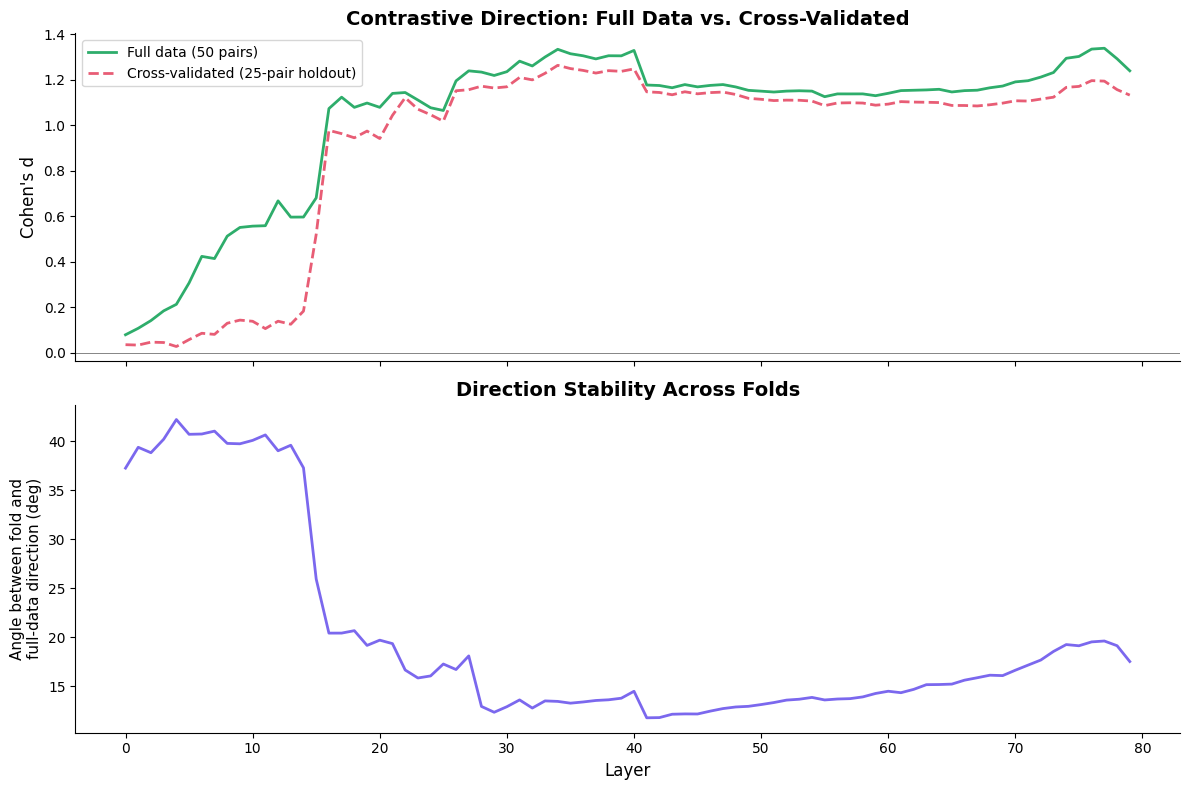

In [9]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

layers = holdout['layer_indices']

# Panel 1: Cohen's d comparison
ax1.plot(layers, holdout['cohens_d_full'], color='#2EAD6B', lw=2, label='Full data (50 pairs)')
ax1.plot(layers, holdout['cohens_d_cv'], color='#E85D75', lw=2, ls='--', label='Cross-validated (25-pair holdout)')
ax1.set_ylabel("Cohen's d", fontsize=12)
ax1.legend(fontsize=10, loc='upper left')
ax1.set_title('Contrastive Direction: Full Data vs. Cross-Validated', fontsize=14, fontweight='bold')
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.axhline(y=0, color='#555', lw=0.5)

# Panel 2: Direction angle
ax2.plot(layers, holdout['direction_angle'], color='#7B68EE', lw=2)
ax2.set_xlabel('Layer', fontsize=12)
ax2.set_ylabel('Angle between fold and\nfull-data direction (deg)', fontsize=11)
ax2.set_title('Direction Stability Across Folds', fontsize=14, fontweight='bold')
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

fig.tight_layout()
plt.show()

In [10]:
# Summary: how well does the direction generalize?
ratio = holdout['cohens_d_cv'] / np.maximum(holdout['cohens_d_full'], 0.01)
sig_mask = holdout['cohens_d_full'] > 0.5

if sig_mask.any():
    sig_layers = np.array(layers)[sig_mask]
    print(f"Layers with full-data Cohen's d > 0.5: {sig_mask.sum()} (layers {sig_layers[0]}-{sig_layers[-1]})")
    print(f"Mean CV/full Cohen's d ratio: {ratio[sig_mask].mean():.2f}")
    print(f"Mean direction angle: {holdout['direction_angle'][sig_mask].mean():.1f} deg")
    print(f"\nInterpretation: CV/full ratio near 1.0 = good generalization.")
    print(f"Small angles = the direction found from half the data agrees with the full-data direction.")
else:
    print("No layers with Cohen's d > 0.5 found.")

Layers with full-data Cohen's d > 0.5: 72 (layers 8-79)
Mean CV/full Cohen's d ratio: 0.87
Mean direction angle: 17.8 deg

Interpretation: CV/full ratio near 1.0 = good generalization.
Small angles = the direction found from half the data agrees with the full-data direction.


---
## 5. Explore Individual Pairs

Pick a pair to see its contrastive projection trajectory across layers.

In [11]:
# Show all pairs with their pun boost ratios
pair_info = []
for s in meta['samples']:
    if s['type'] == 'funny':
        pid = s['pair_id']
        br = boost_ratios.get(pid, 1.0)
        pair_info.append((pid, s.get('joke_c_sentence', ''), br))

pair_info.sort(key=lambda x: -x[2])  # sort by boost ratio descending
print(f"{'Pair':>4}  {'Boost':>7}  Sentence")
print("-" * 80)
for pid, sentence, br in pair_info[:20]:
    br_str = f"{br:.0f}x" if br < 9999 else "inf"
    print(f"{pid:>4}  {br_str:>7}  {sentence[:65]}")
print(f"\n... showing top 20 of {len(pair_info)} pairs by pun-boost ratio")

Pair    Boost  Sentence
--------------------------------------------------------------------------------
  47      inf  Sir Lancelot's armor was rusty because he'd been pulling too many
  31      inf  The Greek architect became a journalist because he totally loved 
  12     136x  The horse breeder's business was always ___
  10     130x  The lizard keeper got a job in IT because he already worked with 
   7     111x  The plumber went to the casino and got a ___
  33      22x  The king was only 12 inches tall, making him a pretty good ___
   2      17x  The wizard ran a fantastic music school because he had a great __
  35      17x  The newspaper editor was always ___ for time
  48      15x  The tailor's business was just ___
  39      13x  The lumberjack's diary was thick because he kept detailed ___
  15      12x  The deli owner was great at ending arguments because he could see
  32       9x  The photographer hated gossip because it always developed into __
  23       9x  The elevat

Pair 31: The Greek architect became a journalist because he totally loved ___
Pun boost ratio: 145208.0x



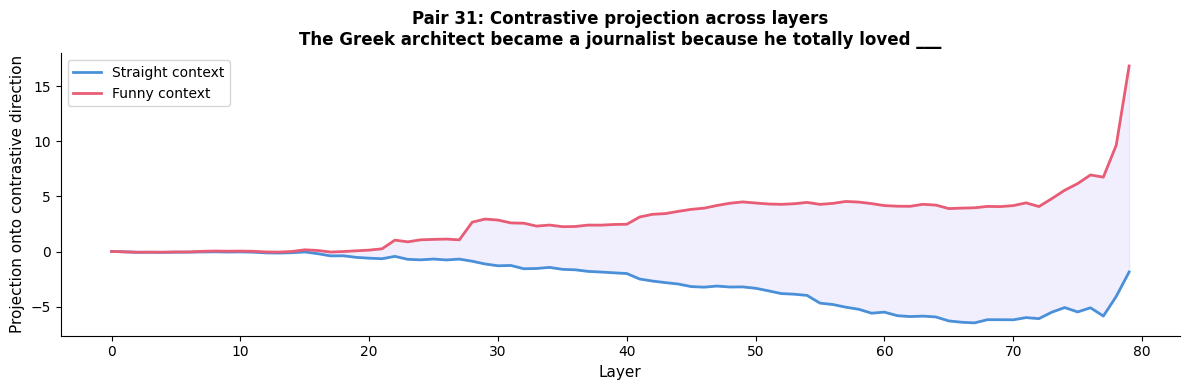

In [12]:
# Trajectory of a single pair across layers on the contrastive axis
PAIR_ID = 31  # <-- change this to explore different pairs

# Find sample indices for this pair
s_idx = f_idx = None
for i, s in enumerate(meta['samples']):
    if s['pair_id'] == PAIR_ID:
        if s['type'] == 'straight': s_idx = i
        else: f_idx = i

if s_idx is not None and f_idx is not None:
    sentence = meta['samples'][f_idx].get('joke_c_sentence', '')
    br = boost_ratios.get(PAIR_ID, 1.0)
    print(f"Pair {PAIR_ID}: {sentence}")
    print(f"Pun boost ratio: {br:.1f}x\n")

    proj_s = []
    proj_f = []
    for li in layer_indices:
        X = layer_data[li]
        d = contrastive_direction(X, meta)
        X_centered = X - X.mean(axis=0)
        projs = X_centered @ d
        proj_s.append(float(projs[s_idx]))
        proj_f.append(float(projs[f_idx]))

    fig, ax = plt.subplots(figsize=(12, 4))
    ax.plot(layer_indices, proj_s, color='#4A90D9', lw=2, label='Straight context')
    ax.plot(layer_indices, proj_f, color='#E85D75', lw=2, label='Funny context')
    ax.fill_between(layer_indices, proj_s, proj_f, alpha=0.1, color='#7B68EE')
    ax.set_xlabel('Layer', fontsize=11)
    ax.set_ylabel('Projection onto contrastive direction', fontsize=11)
    ax.set_title(f'Pair {PAIR_ID}: Contrastive projection across layers\n{sentence}',
                 fontsize=12, fontweight='bold')
    ax.legend(fontsize=10)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    fig.tight_layout()
    plt.show()
else:
    print(f"Pair {PAIR_ID} not found. Valid pair IDs: 0-{max(s['pair_id'] for s in meta['samples'])}")